In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  RobustScaler, FunctionTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout





%matplotlib inline

### Training of neural networks with keras:

Epoch 1/60
15252/15252 [==============================] - 11s 685us/step - loss: 0.3461 - mean_absolute_error: 0.3072 - val_loss: 0.1503 - val_mean_absolute_error: 0.3063
Epoch 2/60
15252/15252 [==============================] - 10s 676us/step - loss: 0.1063 - mean_absolute_error: 0.2284 - val_loss: 0.1093 - val_mean_absolute_error: 0.2343
Epoch 3/60
15252/15252 [==============================] - 10s 665us/step - loss: 0.1009 - mean_absolute_error: 0.2210 - val_loss: 0.0974 - val_mean_absolute_error: 0.2131
Epoch 4/60
15252/15252 [==============================] - 10s 669us/step - loss: 0.0986 - mean_absolute_error: 0.2175 - val_loss: 0.0850 - val_mean_absolute_error: 0.1918
Epoch 5/60
15252/15252 [==============================] - 10s 666us/step - loss: 0.0966 - mean_absolute_error: 0.2149 - val_loss: 0.1038 - val_mean_absolute_error: 0.2252
Epoch 6/60
15252/15252 [==============================] - 10s 673us/step - loss: 0.0951 - mean_absolute_error: 0.2120 - val_loss: 0.0949 - val_me

Epoch 49/60
15252/15252 [==============================] - 13s 830us/step - loss: 0.0826 - mean_absolute_error: 0.1936 - val_loss: 0.0843 - val_mean_absolute_error: 0.1940
Epoch 50/60
15252/15252 [==============================] - 13s 826us/step - loss: 0.0821 - mean_absolute_error: 0.1931 - val_loss: 0.1255 - val_mean_absolute_error: 0.2670
Epoch 51/60
15252/15252 [==============================] - 11s 751us/step - loss: 0.0820 - mean_absolute_error: 0.1932 - val_loss: 0.0842 - val_mean_absolute_error: 0.1984
Epoch 52/60
15252/15252 [==============================] - 11s 735us/step - loss: 0.0818 - mean_absolute_error: 0.1930 - val_loss: 0.0821 - val_mean_absolute_error: 0.1909
Epoch 53/60
15252/15252 [==============================] - 11s 726us/step - loss: 0.0813 - mean_absolute_error: 0.1922 - val_loss: 0.1101 - val_mean_absolute_error: 0.2289
Epoch 54/60
15252/15252 [==============================] - 12s 788us/step - loss: 0.0817 - mean_absolute_error: 0.1927 - val_loss: 0.0798 - 

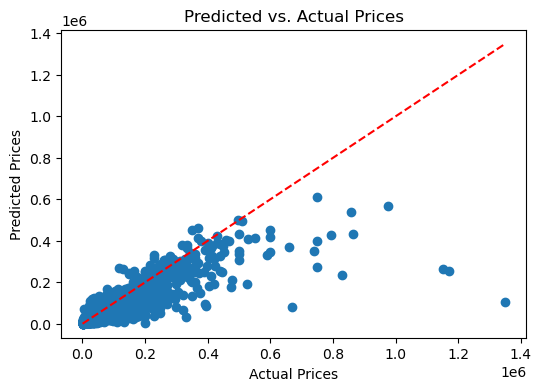

In [2]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable
# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year',  'offer_description', ])
df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Log transform all relevant columns (make sure there are no non-positive valu
df['price_in_euro'] = np.log(df['price_in_euro'] + 1)
df['fuel_consumption_l_100km'] = np.log(df['fuel_consumption_l_100km'] + 1)
df['power_ps'] = np.log(df['power_ps'] + 1)
df['age'] = np.log(df['age'] + 1)
df['Modell_encoded'] = np.log(df['Modell_encoded'] + 1)
df['Brand_encoded'] = np.log(df['Brand_encoded'] + 1)

# Apply Square Root Transformation (only for non-negative values)
df['mileage_in_km'] = np.sqrt(df['mileage_in_km'].clip(lower=0))


X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=10, validation_split=0.2)

# Evaluate the model on test data
y_test_pred = model.predict(X_test).flatten()  # Flatten the predictions

# Calculate metrics
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f"Neural Network MAE: {mae}")
print(f"Neural Network MSE: {mse}")
print(f"Neural Network R²: {r2}")



# Perform inverse log transformation on both predicted and actual prices
y_test_inv = np.exp(y_test) - 1  # Inverse log transform for actual test values
y_pred_inv = np.exp(y_test_pred) - 1  # Inverse log transform for predicted values

# Inverse transforming the test features back to original scale
X_test_inv = X_test.copy()
X_test_inv['mileage_in_km'] = X_test['mileage_in_km'] **2
X_test_inv['fuel_consumption_l_100km'] = np.exp(X_test['fuel_consumption_l_100km']) - 1
X_test_inv['power_ps'] = np.exp(X_test['power_ps']) - 1
X_test_inv['age'] = np.exp(X_test['age']) - 1
#X_test_inv['Modell_encoded'] = np.exp(X_test['Modell_encoded']) - 1
X_test_inv['Brand_encoded'] = np.exp(X_test['Brand_encoded']) - 1

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': np.exp(y_test) - 1,  # Inverse log transform for actual values
    'Predicted Price': y_pred_inv,       # Inversely transformed predicted prices
    'Modell_encoded': X_test_inv['Modell_encoded'],# Not transformed 'Modell_encoded'
    'Year': 2024 - X_test_inv['age'],    # Compute the actual year
    'Fuel_consum': X_test_inv['fuel_consumption_l_100km'],  # Inversely transformed fuel consumption
    'Power_ps': X_test_inv['power_ps']   # Inversely transformed power in PS
})

# Step 5: Extract the original 'model' names from the original df
models_df = df[['Modell_encoded', 'model']].drop_duplicates()  # Ensure unique Modell_encoded values

# Merge the comparison DataFrame with models_df based on 'Modell_encoded'
final_comparison_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')


final_comparison_df.head()

# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(np.exp(y_test) - 1, y_pred_inv, s=5)  # Correctly plot inverse transformed values

plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # Correct diagonal line


plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices')
plt.show()

In [3]:


final_comparison_df.head(20)

,Actual Price,Predicted Price,Modell_encoded,Year,Fuel_consum,Power_ps,model
0,31190.0,30239.070312,10.193258,2023.0,6.8,150.0,Hyundai TUCSON
1,16800.0,15915.184570,10.003649,2007.0,9.5,250.0,Audi TT
2,7500.0,7699.036133,9.521467,2013.0,4.5,82.0,Citroen C3
3,14490.0,13944.730469,9.329677,2020.0,5.9,75.0,Opel Corsa
4,15870.0,17491.232422,9.662704,2020.0,5.4,95.0,SEAT Ibiza
5,13990.0,18459.472656,10.057948,2017.0,5.2,120.0,Ford Kuga
6,49699.0,40363.781250,10.391908,2022.0,5.9,150.0,Volkswagen T6.1 Kombi
7,29900.0,33114.816406,10.641655,2019.0,5.4,150.0,Land Rover Range Rover Evoque
8,34888.0,25287.894531,9.978142,2017.0,6.1,258.0,Mercedes-Benz E 350
9,21489.0,19971.945312,9.525769,2023.0,5.0,101.0,Hyundai i20


In [4]:
# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print the results
print(f"Neural Network MAE: {mae}")
print(f"Neural Network MSE: {mse}")
print(f"Neural Network R²: {r2}")


Neural Network MAE: 4521.202637657437
Neural Network MSE: 228554612.41257897
Neural Network R²: 0.7982449682744178


In [6]:
from tensorflow.keras.layers import Dense, LeakyReLU

#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable
# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year', 'offer_description', ])
df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')


X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable





# List of columns to scale
columns_to_scale = ['mileage_in_km', 'fuel_consumption_l_100km', 'Modell_encoded','Brand_encoded', 'power_ps']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize RobustScaler
scaler = RobustScaler()

# Scale features in X_train and X_test
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# For y_train and y_test, reshape and apply scaling
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

#
# Step 2: Normalize the data (neural networks work better with normalized data)
#scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define the neural network model
model = Sequential()

# Input layer and first hidden layer with 128 neurons
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))




# Output layer for regression (no activation)
model.add(Dense(1))
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Step 4: Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Step 5: Train the model
history_2 = model.fit(X_train, y_train, epochs=60, batch_size=30, validation_split=0.2,callbacks=[early_stopping])

# Step 6: Evaluate the model on test data
y_test_pred = model.predict(X_test)

# Step 7: Calculate metrics
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Step 8: Print the results
print(f"Neural Network MAE: {mae}")
print(f"Neural Network MSE: {mse}")
print(f"Neural Network R²: {r2}")

Epoch 1/60
5084/5084 [==============================] - 10s 2ms/step - loss: 2.0419 - mean_absolute_error: 0.3365 - val_loss: 0.5177 - val_mean_absolute_error: 0.2694
Epoch 2/60
5084/5084 [==============================] - 9s 2ms/step - loss: 1.6852 - mean_absolute_error: 0.2748 - val_loss: 0.4822 - val_mean_absolute_error: 0.2714
Epoch 3/60
5084/5084 [==============================] - 9s 2ms/step - loss: 1.6586 - mean_absolute_error: 0.2698 - val_loss: 0.4478 - val_mean_absolute_error: 0.2541
Epoch 4/60
5084/5084 [==============================] - 9s 2ms/step - loss: 1.6356 - mean_absolute_error: 0.2669 - val_loss: 0.4333 - val_mean_absolute_error: 0.2497
Epoch 5/60
5084/5084 [==============================] - 9s 2ms/step - loss: 1.6273 - mean_absolute_error: 0.2642 - val_loss: 0.4203 - val_mean_absolute_error: 0.2533
Epoch 6/60
5084/5084 [==============================] - 9s 2ms/step - loss: 1.6034 - mean_absolute_error: 0.2630 - val_loss: 0.4304 - val_mean_absolute_error: 0.2509
Epo

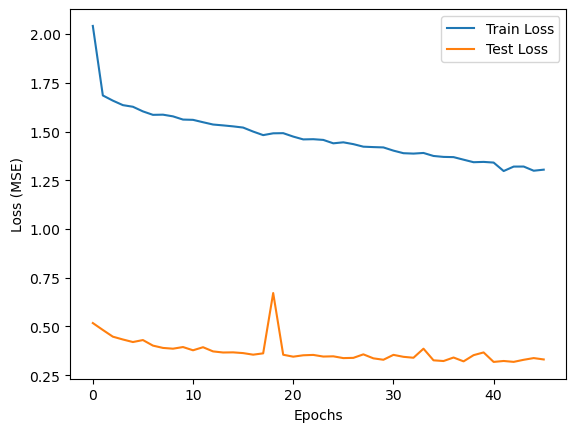

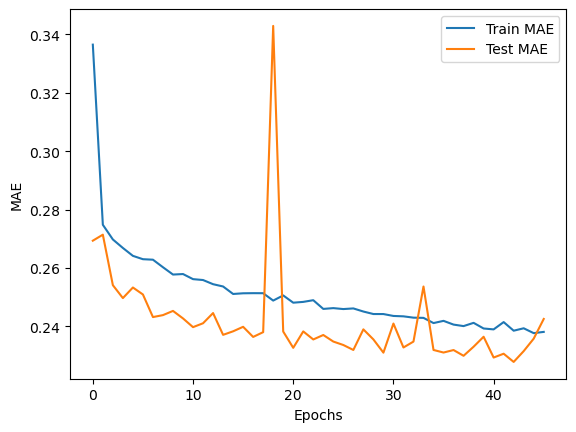

In [7]:
# Plot the training loss and validation loss
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Similarly, for Mean Absolute Error
plt.plot(history_2.history['mean_absolute_error'], label='Train MAE')
plt.plot(history_2.history['val_mean_absolute_error'], label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

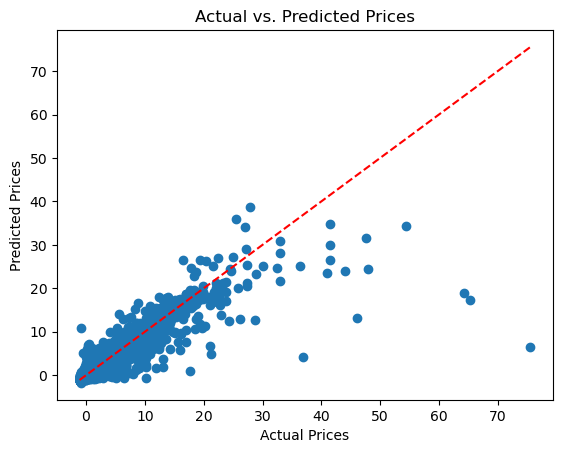

In [8]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Actual vs. Predicted Prices')
plt.show()

### If to remove the outliers:

In [10]:
from scipy import stats
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable
# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year',  'offer_description', ])
df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) < 11)]  #11 is the high threshold for outliers
df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mileagem but not so high threshold

### The first model was used:

Epoch 1/60
15208/15208 [==============================] - 11s 678us/step - loss: 0.5668 - mean_absolute_error: 0.3333 - val_loss: 0.1459 - val_mean_absolute_error: 0.2907
Epoch 2/60
15208/15208 [==============================] - 11s 736us/step - loss: 0.1049 - mean_absolute_error: 0.2275 - val_loss: 0.2179 - val_mean_absolute_error: 0.3977
Epoch 3/60
15208/15208 [==============================] - 12s 786us/step - loss: 0.1008 - mean_absolute_error: 0.2224 - val_loss: 0.1029 - val_mean_absolute_error: 0.2182
Epoch 4/60
15208/15208 [==============================] - 11s 692us/step - loss: 0.0969 - mean_absolute_error: 0.2162 - val_loss: 0.0905 - val_mean_absolute_error: 0.2014
Epoch 5/60
15208/15208 [==============================] - 10s 676us/step - loss: 0.0947 - mean_absolute_error: 0.2126 - val_loss: 0.1045 - val_mean_absolute_error: 0.2257
Epoch 6/60
15208/15208 [==============================] - 11s 716us/step - loss: 0.0931 - mean_absolute_error: 0.2106 - val_loss: 0.0843 - val_me

Epoch 49/60
15208/15208 [==============================] - 10s 668us/step - loss: 0.0818 - mean_absolute_error: 0.1929 - val_loss: 0.0858 - val_mean_absolute_error: 0.1994
Epoch 50/60
15208/15208 [==============================] - 10s 657us/step - loss: 0.0815 - mean_absolute_error: 0.1924 - val_loss: 0.0808 - val_mean_absolute_error: 0.1897
Epoch 51/60
15208/15208 [==============================] - 10s 661us/step - loss: 0.0813 - mean_absolute_error: 0.1924 - val_loss: 0.0824 - val_mean_absolute_error: 0.1927
Epoch 52/60
15208/15208 [==============================] - 10s 653us/step - loss: 0.0815 - mean_absolute_error: 0.1926 - val_loss: 0.0792 - val_mean_absolute_error: 0.1914
Epoch 53/60
15208/15208 [==============================] - 10s 663us/step - loss: 0.0814 - mean_absolute_error: 0.1926 - val_loss: 0.0786 - val_mean_absolute_error: 0.1857
Epoch 54/60
15208/15208 [==============================] - 10s 663us/step - loss: 0.0811 - mean_absolute_error: 0.1918 - val_loss: 0.0838 - 

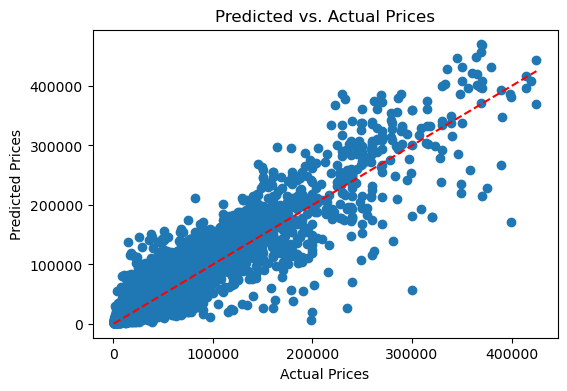

In [11]:
# Log transform all relevant columns (make sure there are no non-positive valu
df_clean['price_in_euro'] = np.log(df_clean['price_in_euro'] + 1)
df_clean['fuel_consumption_l_100km'] = np.log(df_clean['fuel_consumption_l_100km'] + 1)
df_clean['power_ps'] = np.log(df_clean['power_ps'] + 1)
df_clean['age'] = np.log(df_clean['age'] + 1)
df_clean['Modell_encoded'] = np.log(df_clean['Modell_encoded'] + 1)
df_clean['Brand_encoded'] = np.log(df_clean['Brand_encoded'] + 1)

# Apply Square Root Transformation (only for non-negative values)
df_clean['mileage_in_km'] = np.sqrt(df_clean['mileage_in_km'].clip(lower=0))


X = df_clean.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df_clean['price_in_euro']  # Target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history_3 = model.fit(X_train, y_train, epochs=60, batch_size=10, validation_split=0.2)

# Evaluate the model on test data
y_test_pred = model.predict(X_test).flatten()  # Flatten the predictions

# Calculate metrics
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f"Neural Network MAE: {mae}")
print(f"Neural Network MSE: {mse}")
print(f"Neural Network R²: {r2}")



# Perform inverse log transformation on both predicted and actual prices
y_test_inv = np.exp(y_test) - 1  # Inverse log transform for actual test values
y_pred_inv = np.exp(y_test_pred) - 1  # Inverse log transform for predicted values

# Inverse transforming the test features back to original scale
X_test_inv = X_test.copy()
X_test_inv['mileage_in_km'] = X_test['mileage_in_km'] **2
X_test_inv['fuel_consumption_l_100km'] = np.exp(X_test['fuel_consumption_l_100km']) - 1
X_test_inv['power_ps'] = np.exp(X_test['power_ps']) - 1
X_test_inv['age'] = np.exp(X_test['age']) - 1
#X_test_inv['Modell_encoded'] = np.exp(X_test['Modell_encoded']) - 1
X_test_inv['Brand_encoded'] = np.exp(X_test['Brand_encoded']) - 1

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': np.exp(y_test) - 1,  # Inverse log transform for actual values
    'Predicted Price': y_pred_inv,       # Inversely transformed predicted prices
    'Modell_encoded': X_test_inv['Modell_encoded'],# Not transformed 'Modell_encoded'
    'Year': 2024 - X_test_inv['age'],    # Compute the actual year
    'Fuel_consum': X_test_inv['fuel_consumption_l_100km'],  # Inversely transformed fuel consumption
    'Power_ps': X_test_inv['power_ps']   # Inversely transformed power in PS
})

# Step 5: Extract the original 'model' names from the original df
models_df = df_clean[['Modell_encoded', 'model']].drop_duplicates()  # Ensure unique Modell_encoded values

# Merge the comparison DataFrame with models_df based on 'Modell_encoded'
final_comparison_out_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')




# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(np.exp(y_test) - 1, y_pred_inv)  # Correctly plot inverse transformed values

plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # Correct diagonal line


plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices')
plt.show()

In [12]:
final_comparison_out_df.head(20)

,Actual Price,Predicted Price,Modell_encoded,Year,Fuel_consum,Power_ps,model
0,10800.0,13688.279297,9.715968,2010.0,5.3,184.0,BMW 320
1,16990.0,23131.835938,9.698664,2017.0,4.3,190.0,BMW 120
2,11800.0,12020.718750,8.940062,2010.0,7.0,95.0,Mercedes-Benz A 160
3,12990.0,17053.871094,9.880489,2017.0,6.0,99.0,Kia Ceed / cee'd
4,14900.0,17509.808594,10.168853,2014.0,5.8,177.0,SEAT Alhambra
5,6999.0,8289.710938,9.375528,2013.0,4.2,69.0,Kia Picanto
6,34900.0,39202.222656,10.320359,2015.0,8.0,333.0,Audi A6 allroad
7,104991.0,129165.429688,11.962662,2014.0,10.0,400.0,Porsche 991
8,30900.0,40425.187500,10.543751,2020.0,5.7,150.0,Land Rover Discovery Sport
9,4590.0,8073.888184,9.414903,2006.0,8.0,140.0,Opel Astra


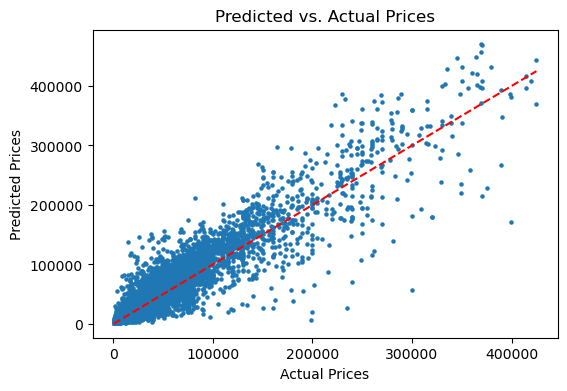

In [13]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(np.exp(y_test) - 1, y_pred_inv, s=5)  # Correctly plot inverse transformed values
plt.plot([min(np.exp(y_test) - 1), max(np.exp(y_test) - 1)], [min(np.exp(y_test) - 1), max(np.exp(y_test) - 1)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices')
plt.show()

In [14]:
# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print the results
print(f"Neural Network MAE: {mae}")
print(f"Neural Network MSE: {mse}")
print(f"Neural Network R²: {r2}")


Neural Network MAE: 5339.742233094321
Neural Network MSE: 115313490.94385192
Neural Network R²: 0.8449011463423276
